In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [2]:
# Create submission folder if it doesn't exist
submission_dir = './submission'
os.makedirs(submission_dir, exist_ok=True)

# Uncomment the following block ONLY if you wish to inspect file paths in a Kaggle-like directory structure.
# On your local system, you likely have the files in your local folder so this is not needed.
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


# Data Loading for Local Environment
# Files are assumed to be in:
# ./cse-251-b-2025/train.npz
# ./cse-251-b-2025/test_input.npz

train_file = np.load("./cse-251-b-2025/train.npz")
train_data = train_file['data']
print("train_data's shape:", train_data.shape)  # Expected shape: (10000, 50, 110, 6)

test_file = np.load("./cse-251-b-2025/test_input.npz")
test_data = test_file['data']
print("test_data's shape:", test_data.shape)    # Expected shape: (2100, 50, 50, 6)

train_data's shape: (10000, 50, 110, 6)
test_data's shape: (2100, 50, 50, 6)


# Visualization: 

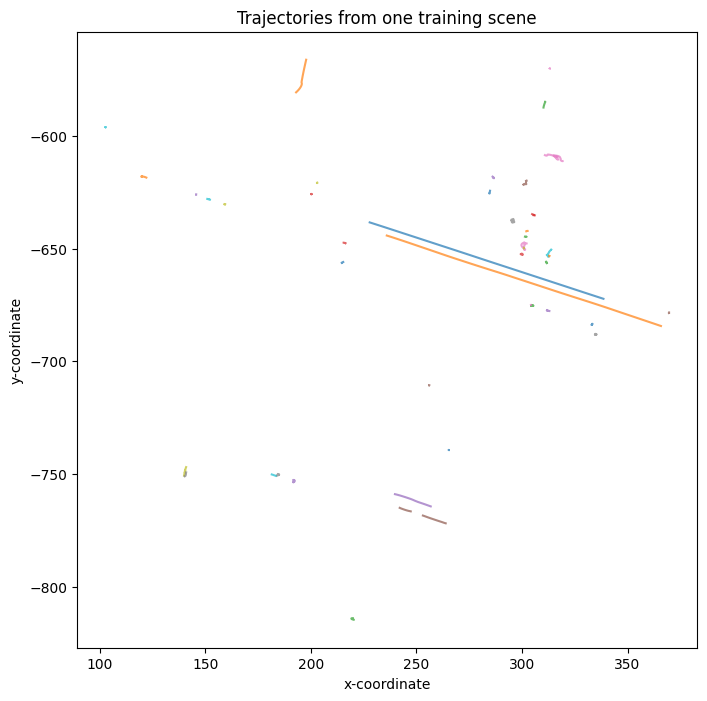

C:\Users\mana\AppData\Local\Temp\ipykernel_11872\131605193.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', 50)


In [3]:
#Plot trajectories from one training scene (static plot)
data_matrix = train_data[0]

plt.figure(figsize=(8, 8))
for agent in range(data_matrix.shape[0]):
    xs = data_matrix[agent, :, 0]
    ys = data_matrix[agent, :, 1]
    # Remove zeros (padding)
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    plt.plot(xs, ys, alpha=0.7)
plt.title("Trajectories from one training scene")
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.show()

#Create an animated gif for one training scene (exact code provided on kaggle)
def make_gif(data_matrix, name='example'):
    cmap = plt.cm.get_cmap('viridis', 50)
    fig, ax = plt.subplots(figsize=(10, 10))
    # Function to update plot for each frame
    def update(frame):
        ax.clear()
        # Get data for current timestep
        for i in range(1, data_matrix.shape[0]):
            x = data_matrix[i, frame, 0]
            y = data_matrix[i, frame, 1]
            if x != 0 and y != 0:
                xs = data_matrix[i, :frame+1, 0]  # Include current frame
                ys = data_matrix[i, :frame+1, 1]  # Include current frame
                # trim all zeros
                mask = (xs != 0) & (ys != 0)  # Only keep points where both x and y are non-zero
                xs = xs[mask]
                ys = ys[mask]
                # Only plot if we have points to plot
                if len(xs) > 0 and len(ys) > 0:
                    color = cmap(i)
                    ax.plot(xs, ys, alpha=0.9, color=color)
                    ax.scatter(x, y, s=80, color=color)
        ax.plot(data_matrix[0, :frame, 0], data_matrix[0, :frame, 1],
                color='tab:orange', label='Ego Vehicle')
        ax.scatter(data_matrix[0, frame, 0], data_matrix[0, frame, 1],
                   s=80, color='tab:orange')
        # Set title with timestep
        ax.set_title(f'Timestep {frame}')
        # Set consistent axis limits
        ax.set_xlim(data_matrix[:,:,0][data_matrix[:,:,0] != 0].min() - 10, 
                    data_matrix[:,:,0][data_matrix[:,:,0] != 0].max() + 10)
        ax.set_ylim(data_matrix[:,:,1][data_matrix[:,:,1] != 0].min() - 10, 
                    data_matrix[:,:,1][data_matrix[:,:,1] != 0].max() + 10)
        ax.legend()
        return ax.collections + ax.lines

    # Create animation
    anim = animation.FuncAnimation(fig, update, frames=list(range(0, data_matrix.shape[1], 3)),
                                   interval=100, blit=True)
    # Save as GIF
    anim.save(f'trajectory_visualization_{name}.gif', writer='pillow')
    plt.close()

data_matrix = train_data[0]        
make_gif(data_matrix, 'index0')

# Baseline 1: Constant Velocity Model for Test Set:

In [4]:
# Compute the velocity differences for the ego vehicle (agent index 0)
velocity_diff = test_data[..., 1:, :2] - test_data[..., :-1, :2]
print("Velocity difference shape:", velocity_diff.shape)

# Compute average velocity for the ego vehicle (index 0) in each scene
constant_vel = np.mean(velocity_diff[:, 0, :, :], axis=1)
print("Constant velocity shape:", constant_vel.shape)

# Generate predictions for 60 future time steps based on constant velocity
pred_y_const = np.zeros((test_data.shape[0], 60, 2))
starting_point = test_data[:, 0, -1, :2]  # Last observed position of ego vehicle

for t in range(60):
    pred_y_const[:, t, :] = starting_point + (t + 1) * constant_vel

# Reshape predictions to submission format: (2100, 60, 2) -> (12600, 2)
pred_output_const = pred_y_const.reshape(-1, 2)
output_df_const = pd.DataFrame(pred_output_const, columns=['x', 'y'])
output_df_const.index.name = 'index'
# Save output in the submission folder
constant_vel_path = os.path.join(submission_dir, 'constant_vel_submission.csv')
output_df_const.to_csv(constant_vel_path)
print(f"Constant velocity submission saved locally as '{constant_vel_path}'.")

Velocity difference shape: (2100, 50, 49, 2)
Constant velocity shape: (2100, 2)
Constant velocity submission saved locally as './submission\constant_vel_submission.csv'.


# Baseline 2: MLP Model using PyTorch:

In [5]:
# Prepare training data: use first 50 time steps as input and last 60 time steps of the ego vehicle as output
train_x = train_data[..., :50, :]     # Shape: (10000, 50, 50, 6)
train_y = train_data[:, 0, 50:, :2]     # Shape: (10000, 60, 2)
print("Train x shape:", train_x.shape, "Train y shape:", train_y.shape)

# Define the MLP model architecture
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, output_features)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.mlp(x)
        return x

# Calculate number of input features after flattening and number of output features
input_features = 50 * 50 * 6   # 50 agents, 50 time steps, 6 dimensions each
output_features = 60 * 2       # 60 future time steps, 2 dimensions (x, y)

# Create the model, loss criterion, and optimizer
model = MLP(input_features, output_features)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the training loop for the MLP model
def train_model(model, x_train, y_train, batch_size=64, epochs=10):
    # Convert numpy arrays to PyTorch tensors and reshape
    X_train_tensor = torch.FloatTensor(x_train).reshape((-1, input_features))
    y_train_tensor = torch.FloatTensor(y_train).reshape((-1, output_features))
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1} Loss: {running_loss/len(train_loader):.4f}')
    return model

# Train the model (tweak batch_size and epochs as needed)
model = train_model(model, train_x, train_y, batch_size=64, epochs=10)

# Define a function for prediction on the test set
def predict(X_test):
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test).reshape((-1, input_features))
        predictions = model(X_test_tensor).reshape((-1, 60, 2))
    return predictions.numpy()

# Make predictions on the test set using the trained MLP
pred_y_mlp = predict(test_data)

# Reshape predictions to match submission format: (2100, 60, 2) -> (12600, 2)
pred_output_mlp = pred_y_mlp.reshape(-1, 2)
output_df_mlp = pd.DataFrame(pred_output_mlp, columns=['x', 'y'])
output_df_mlp.index.name = 'index'

# Save output in the submission folder
mlp_submission_path = os.path.join(submission_dir, 'mlp_baseline_submission.csv')
output_df_mlp.to_csv(mlp_submission_path)
print(f"MLP baseline submission saved locally as '{mlp_submission_path}'.")

Train x shape: (10000, 50, 50, 6) Train y shape: (10000, 60, 2)


Epoch 1: 100%|██████████| 157/157 [00:07<00:00, 20.56it/s]


Epoch 1 Loss: 696893.6954


Epoch 2: 100%|██████████| 157/157 [00:06<00:00, 23.93it/s]


Epoch 2 Loss: 338198.5917


Epoch 3: 100%|██████████| 157/157 [00:06<00:00, 23.07it/s]


Epoch 3 Loss: 293539.3150


Epoch 4: 100%|██████████| 157/157 [00:06<00:00, 23.35it/s]


Epoch 4 Loss: 250709.1480


Epoch 5: 100%|██████████| 157/157 [00:06<00:00, 22.88it/s]


Epoch 5 Loss: 225095.3604


Epoch 6: 100%|██████████| 157/157 [00:07<00:00, 21.05it/s]


Epoch 6 Loss: 215546.0087


Epoch 7: 100%|██████████| 157/157 [00:07<00:00, 21.34it/s]


Epoch 7 Loss: 211052.1034


Epoch 8: 100%|██████████| 157/157 [00:07<00:00, 21.42it/s]


Epoch 8 Loss: 181271.6601


Epoch 9: 100%|██████████| 157/157 [00:07<00:00, 21.67it/s]


Epoch 9 Loss: 146905.1440


Epoch 10: 100%|██████████| 157/157 [00:07<00:00, 21.54it/s]


Epoch 10 Loss: 166450.3803
MLP baseline submission saved locally as './submission\mlp_baseline_submission.csv'.


In [6]:
# Functions to save and load the MLP model
def save_model(model, path="mlp_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def load_model(path="mlp_model.pth"):
    loaded_model = MLP(input_features, output_features)
    loaded_model.load_state_dict(torch.load(path))
    loaded_model.eval()
    return loaded_model

# Example usage:
# save_model(model)
# model = load_model()
